In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
from collections import defaultdict 
import jax
import flax
import chex
from jaxtyping import ArrayLike
from typing import Union, TypeVar
import numpy as np
import matplotlib.pyplot as plt

from tracr.compiler.validating import validate
from tracr.rasp.rasp import Map, SequenceMap, LinearSequenceMap, Select, Aggregate, Comparison, SelectorWidth, indices, tokens 
from tracr.rasp import rasp
from tracr.compiler import compiling
from tracr.compiler.assemble import AssembledTransformerModel
from tracr.compiler.craft_model_to_transformer import NoTokensError
from tracr.compiler.basis_inference import InvalidValueSetError
from tracr.compiler import rasp_to_graph

from rasp_tokenizer import tokenizer
from rasp_tokenizer import vocab
from rasp_tokenizer.compiling import COMPILER_BOS
from rasp_generator.utils import sample_test_input, FunctionWithRepr, annotate_type
from rasp_generator import sampling, utils, map_primitives
from rasp_tokenizer import paths
from rasp_tokenizer import vocab, data_utils, lib


rng = np.random.default_rng(0)

In [17]:
p = lib.examples[2]

In [19]:
utils.print_program(p)

select_10 = Select(indices, indices, predicate=Comparison.LEQ)
select_12 = Select(indices, indices, predicate=Comparison.LEQ)
map_11 = Map(lambda x: x == 0, tokens)    # type: Encoding.NUMERICAL
map_13 = Map(lambda x: x == 1, tokens)    # type: Encoding.NUMERICAL
aggregate_8 = Aggregate(select_10, map_11)    # type: Encoding.NUMERICAL
aggregate_9 = Aggregate(select_12, map_13)    # type: Encoding.NUMERICAL
linear_sequence_map_7 = LinearSequenceMap(aggregate_8, aggregate_9, 1, -1)    # type: Encoding.NUMERICAL


In [5]:
model = compiling.compile_rasp_to_model(p, vocab={0,1,2,3,4}, max_seq_len=5)

2024-01-31 20:40:48.864423: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [7]:
type(model.params)

dict

In [8]:
model.params.keys()

dict_keys(['pos_embed', 'token_embed', 'transformer/layer_0/attn/key', 'transformer/layer_0/attn/linear', 'transformer/layer_0/attn/query', 'transformer/layer_0/attn/value', 'transformer/layer_0/mlp/linear_1', 'transformer/layer_0/mlp/linear_2', 'transformer/layer_1/attn/key', 'transformer/layer_1/attn/linear', 'transformer/layer_1/attn/query', 'transformer/layer_1/attn/value', 'transformer/layer_1/mlp/linear_1', 'transformer/layer_1/mlp/linear_2'])

In [15]:
jax.tree_map(lambda x: x.shape, model.params)

{'pos_embed': {'embeddings': (6, 18)},
 'token_embed': {'embeddings': (7, 18)},
 'transformer/layer_0/attn/key': {'b': (14,), 'w': (18, 14)},
 'transformer/layer_0/attn/linear': {'b': (18,), 'w': (14, 18)},
 'transformer/layer_0/attn/query': {'b': (14,), 'w': (18, 14)},
 'transformer/layer_0/attn/value': {'b': (14,), 'w': (18, 14)},
 'transformer/layer_0/mlp/linear_1': {'b': (4,), 'w': (18, 4)},
 'transformer/layer_0/mlp/linear_2': {'b': (18,), 'w': (4, 18)},
 'transformer/layer_1/attn/key': {'b': (14,), 'w': (18, 14)},
 'transformer/layer_1/attn/linear': {'b': (18,), 'w': (14, 18)},
 'transformer/layer_1/attn/query': {'b': (14,), 'w': (18, 14)},
 'transformer/layer_1/attn/value': {'b': (14,), 'w': (18, 14)},
 'transformer/layer_1/mlp/linear_1': {'b': (4,), 'w': (18, 4)},
 'transformer/layer_1/mlp/linear_2': {'b': (18,), 'w': (4, 18)}}

In [12]:
model.params['transformer/layer_0/mlp/linear_1']['w'].shape

(18, 4)

In [14]:
import pickle

In [16]:
with open("params.pkl", "wb") as f:
    pickle.dump(model.params, f)

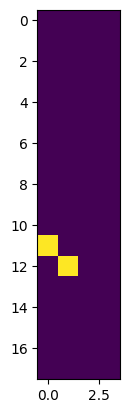

In [13]:
plt.imshow(model.params['transformer/layer_0/mlp/linear_1']['w'])

In [2]:
lib = data_utils.load_batches(loadpath=paths.data_dir / "deduped" / "lib")
print(len(lib))
print(lib[0].keys())
print([p['n_sops'] for p in lib])

3
dict_keys(['weights_and_tokens', 'name', 'n_sops'])
[2, 6, 7]


In [4]:
lib = data_utils.load_and_process_data(name="lib")

print(lib.keys())
print(lib['weights'].shape)
print(lib['rasp_tok'].shape)

2024-01-31 17:34:38 [INFO]: Loading data from /home/lauro/projects/meta-models/rasp-generator/data/deduped/lib.
2024-01-31 17:34:38 [WARNING]: Requested 10000 datapoints for lib, but only 14 available.


dict_keys(['rasp_tok', 'weights', 'program_id'])
(14, 128, 64)
(14, 32)
